__Curate longitudinal dataset based on Ann-Kathrins pathology labels__

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import mne
import pandas as pd
import numpy as np

from braindecode.datasets.base import BaseDataset, BaseConcatDataset

In [2]:
description = pd.read_csv('/home/jovyan/mne_data/TUH/final_tuabEx_description.csv', index_col=0)
description.shape

(33660, 18)

In [3]:
def extract_longitudinal_dataset_new(description, kind, load):
    assert kind in ['transition', 'pathological', 'non_pathological']
    dfs = []
    for s, g in description.groupby('subject'):
        if len(g) > 1:
            if g.pathological.nunique() == 2:
                if kind == 'transition':
                        dfs.append(g)
            else:
                if kind == 'pathological':
                    if g.pathological.unique() == 1:
                        dfs.append(g)
                elif kind == 'non_pathological':
                    if g.pathological.unique() == 0:
                        dfs.append(g)
    dfs = pd.concat(dfs)
    dfs = dfs.reset_index(drop=True)
    if kind == 'transition':
        assert all(dfs.groupby('subject').pathological.nunique() == 2)
    else:
        if kind in ['pathological', 'non_pathological']:
            assert all(dfs.groupby('subject').pathological.nunique() == 1)
    print("n recs", len(dfs), "n subj", dfs.subject.nunique())
    if not load:
        return dfs
    else:
        dfs = dfs.T
        ds = []
        for i, s in dfs.iteritems():
            p = s.path
            p = p.replace('/data/datasets/TUH/EEG/tuh_eeg/', '/home/jovyan/mne_data/TUH_PRE/tuh_eeg/')
            if not os.path.exists(p):
                raise RuntimeError("rec not found")
            raw = mne.io.read_raw_edf(p, preload=False, verbose='error')
            d = BaseDataset(raw, s, target_name='age')
            ds.append(d)
        ds = BaseConcatDataset(ds)
        return ds

In [4]:
df = extract_longitudinal_dataset_new(description, 'transition', False)

n recs 3357 n subj 525


In [6]:
df = extract_longitudinal_dataset_new(description, 'pathological', False)

n recs 18338 n subj 2892


In [8]:
df = extract_longitudinal_dataset_new(description, 'non_pathological', False)

n recs 4068 n subj 956


In [4]:
ds = extract_longitudinal_dataset_new(description, 'transition', True)

n recs 3357 n subj 525


In [6]:
with open('/home/jovyan/longitudinal/transition.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [7]:
ds = extract_longitudinal_dataset_new(description, 'non_pathological', True)

n recs 4068 n subj 956


In [8]:
with open('/home/jovyan/longitudinal/non_pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [9]:
ds = extract_longitudinal_dataset_new(description, 'pathological', True)

n recs 18338 n subj 2892


In [10]:
with open('/home/jovyan/longitudinal/pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

__Plot longitudinal datasets__

In [4]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import torch
import numpy as np
import pandas as pd
from skorch.callbacks import Checkpoint
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

from braindecode.preprocessing import Preprocessor, preprocess
from braindecode import EEGRegressor
from braindecode.models import ShallowFBCSPNet

from decode_tueg import _create_windows as create_windows

In [5]:
def plot_age_hist2(description, ax=None, hue_key=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 2))
    sns.histplot(
        data=description,
        bins=np.linspace(0,100,101,dtype=int),
        x='age',
        kde=True,
        ax=ax,
        hue=hue_key,
    );
    return ax
    #ax.set_title(f'train (n={len(train_set.datasets)})')
    #fig.savefig('/home/jovyan/train_dist_wo_gender.jpg', bbox_inches='tight')

In [6]:
with open('/home/jovyan/longitudinal/transition.pkl', 'rb') as f:
    ds = pickle.load(f)

In [46]:
n_channels = len(ds[0][0])

Text(0, 0.5, 'Count')

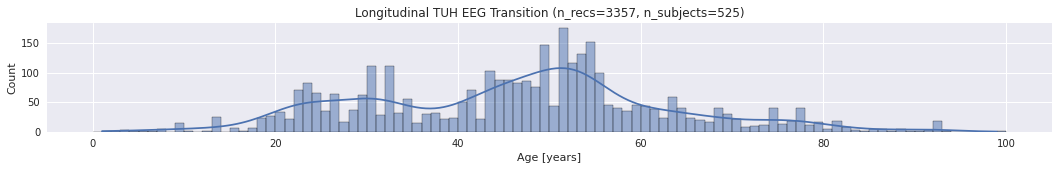

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key=None, ax=ax)
ax.set_title(f"Longitudinal TUH EEG Transition (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
#fig.savefig('/home/jovyan/longitudinal/transition_hist.jpg', bbox_inches='tight')

In [54]:
with open('/home/jovyan/longitudinal/non_pathological.pkl', 'rb') as f:
    ds = pickle.load(f)

In [55]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

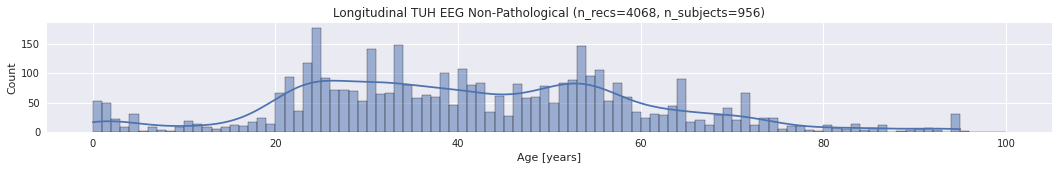

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key=None, ax=ax)
ax.set_title(f"Longitudinal TUH EEG Non-Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
#fig.savefig('/home/jovyan/longitudinal/non_pathological_hist.jpg', bbox_inches='tight')

In [58]:
with open('/home/jovyan/longitudinal/pathological.pkl', 'rb') as f:
    ds = pickle.load(f)

In [59]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

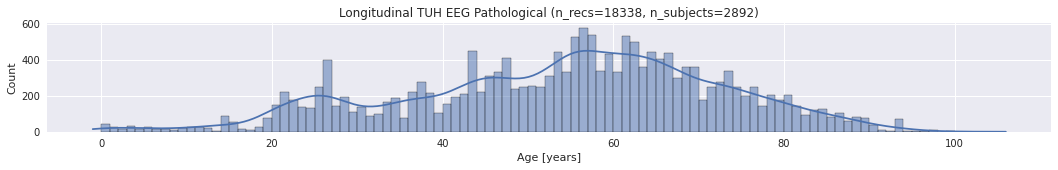

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key=None, ax=ax)
ax.set_title(f"Longitudinal TUH EEG Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
fig.savefig('/home/jovyan/longitudinal/pathological_hist.jpg', bbox_inches='tight')

__Predict longitudinal datasets__

In [15]:
base_path = '/home/jovyan/outdated_runs/tmp/'
#exp_name = 'TUAB, 1089–281 normal, 60s–360s, age, shallow, 35–0, identity, valid'
exp_name = 'TUAB, 1089–281 normal, 60s–-1s, age, tcn, 30–2, huber, random, valid'
in_dir = os.path.join(base_path, exp_name)

In [16]:
config = pd.read_csv(os.path.join(in_dir, 'config.csv'), index_col=0).squeeze()
tmin = int(config['tmin'])
window_size_samples = int(config['window_size_samples'])
preload = False if config['preload'] == '0' else True
n_jobs = 8

In [17]:
point = 'valid_best' #  'train_end'

In [18]:
with open(os.path.join(in_dir, 'checkpoint', f'{point}_model.pkl'), 'rb') as f:
    clf = pickle.load(f)

In [19]:
clf.module.training

False

In [11]:
t = torch.ones(1, n_channels, window_size_samples, 1).cuda()
n_preds_per_input = clf.module(t).size()[2]

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [12]:
with open(os.path.join(in_dir, 'data_scaler.pkl'), 'rb') as f:
    data_scaler = pickle.load(f)
with open(os.path.join(in_dir, 'target_scaler.pkl'), 'rb') as f:
    target_scaler = pickle.load(f)

In [13]:
all_preds = {}
for i, (subj, subj_ds) in enumerate(ds.split('subject').items()):
    subj_ds = preprocess(
        subj_ds,
        preprocessors=[Preprocessor('crop', tmin=tmin)],
    )
    # create windows
    subj_ds = create_windows(
        mapping=None,
        tuabn=subj_ds,
        window_size_samples=window_size_samples,
        n_channels=n_channels,
        n_jobs=n_jobs,
        preload=preload,
        n_preds_per_input=n_preds_per_input,
        test_name='',
    )
    
    # set data and target scaling transform
    #print('prior scaling')
    #print(subj_ds[0][0][0][0])
    #print(subj_ds[0][1])
    subj_ds.transform = data_scaler
    subj_ds.target_transform = target_scaler
    #print('post scaling')
    #print(subj_ds[0][0][0][0])
    #print(subj_ds[0][1])
    
    # make trialswise predictions
    trial_preds, trial_targets = clf.predict_trials(subj_ds, return_targets=True)
    trial_preds = [np.mean(preds, axis=-1).item() for preds in trial_preds]
    trial_preds = [target_scaler.invert(pred) for pred in trial_preds]
    ages = subj_ds.description['age'].to_list()
    year = subj_ds.description['year'].to_list()
    month = subj_ds.description['month'].to_list()
    day = subj_ds.description['day'].to_list()
    pathological = subj_ds.description['pathological'].to_list()
    df = pd.DataFrame(
        np.stack([trial_preds, ages, pathological, year, month, day], axis=1),
        columns=['y_pred', 'y_true', 'pathological', 'year', 'month', 'day'],
    )
    all_preds[subj] = df

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "
/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior

In [14]:
print("hi")

hi


In [8]:
all_preds_df = pd.read_csv(os.path.join(in_dir, 'preds', 'longitudinal_trial_preds.csv'), index_col=0)

In [9]:
all_preds_df

,subject,y_pred,y_true,pathological,year,month,day
0,5,-60.108707,49.0,1.0,2002.0,9.0,19.0
1,5,39.106122,49.0,1.0,2002.0,9.0,19.0
2,5,34.389294,50.0,1.0,2003.0,4.0,16.0
3,5,28.539281,51.0,0.0,2004.0,5.0,20.0
4,5,58.225292,52.0,1.0,2005.0,5.0,3.0
...,...,...,...,...,...,...,...
3352,14951,44.856684,43.0,1.0,2016.0,6.0,15.0
3353,14951,47.202780,43.0,1.0,2016.0,6.0,15.0
3354,14951,48.686130,43.0,1.0,2016.0,6.0,15.0
3355,14951,46.320801,43.0,1.0,2016.0,6.0,15.0


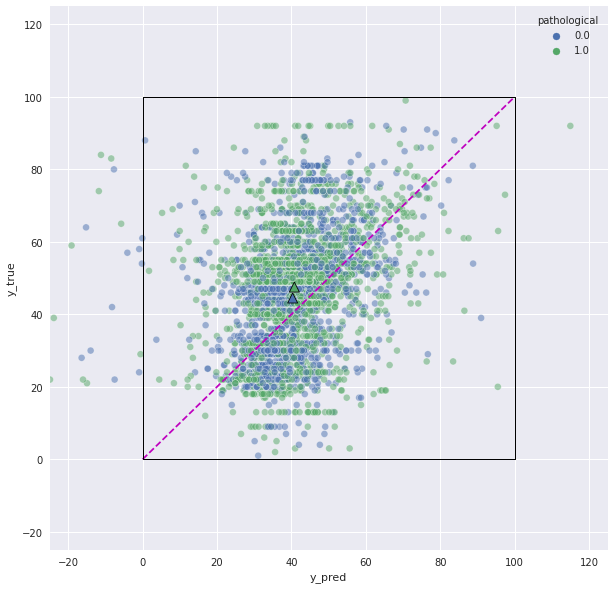

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
colors = {0: 'b', 1: 'r'}
sns.scatterplot(
    data=all_preds_df,
    ax=ax, hue='pathological', x='y_pred', y='y_true', 
    alpha=.5,
)
sns.scatterplot(
    data=all_preds_df.groupby('pathological', as_index=False).mean(),  # median looks better
    ax=ax, hue='pathological', x='y_pred', y='y_true', marker='^',
    edgecolor='black', s=100, legend=False,
)

# set limits
minv = -25
maxv = 125
ax.set_xlim((minv, maxv));
ax.set_ylim((minv, maxv));

# draw bounding box around years 0, 100
minv = 0
maxv = 100
ax.plot([minv, maxv], [minv, maxv], c='m', linestyle='--')
ax.plot([minv, maxv], [maxv, maxv], c='black', linewidth=1)
ax.plot([minv, minv], [minv, maxv], c='black', linewidth=1)
ax.plot([minv, maxv], [minv, minv], c='black', linewidth=1)
ax.plot([maxv, maxv], [maxv, minv], c='black', linewidth=1)
fig.savefig(os.path.join(in_dir, 'plots', 'longitudinal_chronological_vs_predicted_age.jpg'), bbox_inches='tight')

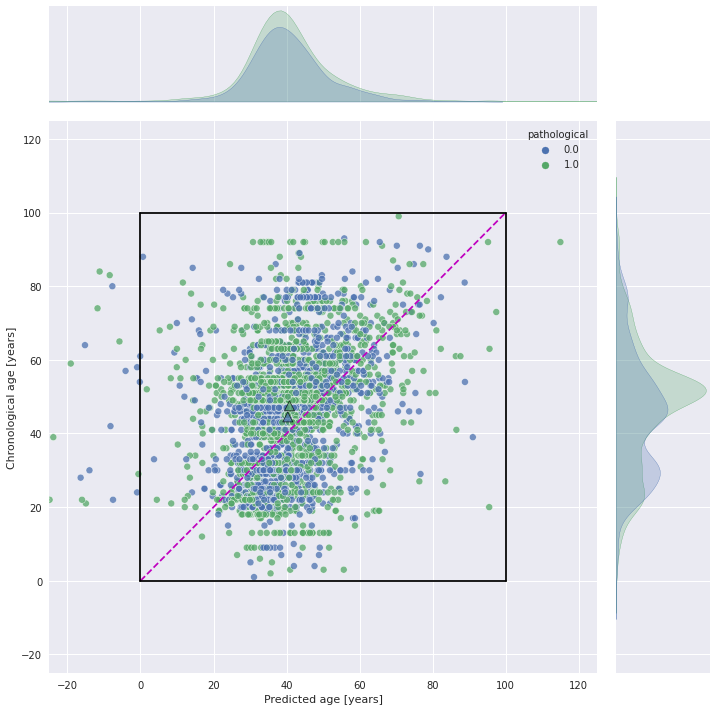

In [11]:
grid = sns.jointplot(data=all_preds_df, x='y_pred', y='y_true', hue='pathological', alpha=.75, height=10)
sns.scatterplot(
    data=all_preds_df.groupby('pathological', as_index=False).mean(),  # median looks better
    ax=grid.ax_joint, hue='pathological', x='y_pred', y='y_true', marker='^',
    edgecolor='black', s=100, legend=False, alpha=.75,
)
grid.ax_joint.set_xlim(-25, 125)
grid.ax_joint.set_ylim(-25, 125)
grid.ax_joint.plot([0,100],[0,100], c='m', linestyle='--')
grid.ax_joint.plot([0, 100], [0, 0], c='k')
grid.ax_joint.plot([0, 0], [0, 100], c='k')
grid.ax_joint.plot([0, 100], [100, 100], c='k')
grid.ax_joint.plot([100, 100], [0, 100], c='k')
grid.ax_joint.set_xlabel('Predicted age [years]')
grid.ax_joint.set_ylabel('Chronological age [years]')
fig.savefig(os.path.join(in_dir, 'plots', 'jointplot.jpg'), bbox_inches='tight')

In [12]:
for n, g in all_preds_df.groupby('pathological'):
    m, b = np.polyfit(g.y_true.to_numpy('int'), g.y_pred.to_numpy('float'), deg=1)
    grid.ax_joint.plot(g.y_true, m*g.y_true + b, label='trend', linewidth=1)

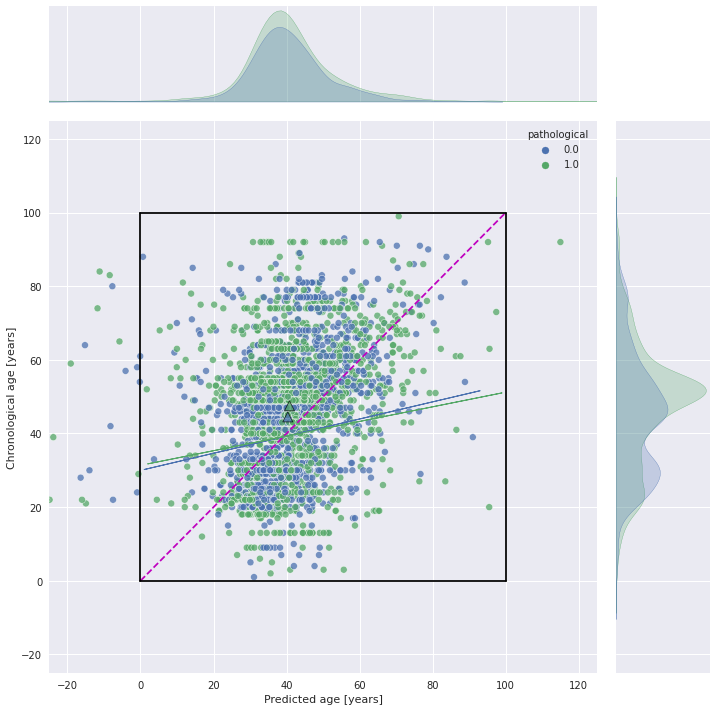

In [13]:
grid.fig

In [14]:
all_preds_df['gap'] = all_preds_df.y_true - all_preds_df.y_pred

In [15]:
avg_all_preds_df = all_preds_df.groupby(['subject', 'pathological'], as_index=False).mean()

In [16]:
avg_all_preds_df

,subject,pathological,y_pred,y_true,year,month,day,gap
0,5,0.0,28.539281,51.0,2004.0,5.000000,20.000000,22.460719
1,5,1.0,24.515273,50.6,2003.6,6.600000,13.200000,26.084727
2,15,0.0,41.635833,46.5,2002.5,11.500000,2.500000,4.864167
3,15,1.0,38.607909,59.0,2015.0,12.000000,28.000000,20.392091
4,16,0.0,39.344887,26.0,2012.0,6.750000,16.250000,-13.344887
...,...,...,...,...,...,...,...,...
1045,14672,1.0,36.713184,49.0,2016.0,5.750000,16.500000,12.286816
1046,14840,0.0,30.187040,35.0,2016.0,5.000000,26.000000,4.812960
1047,14840,1.0,35.600781,35.0,2016.0,6.000000,30.000000,-0.600781
1048,14951,0.0,37.157714,43.0,2016.0,5.333333,13.000000,5.842286


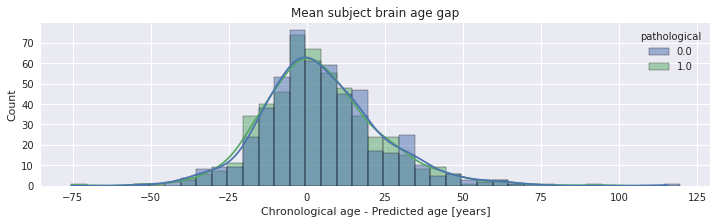

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.histplot(data=avg_all_preds_df, x='gap', hue='pathological', kde=True, ax=ax, binwidth=5)
ax.set_xlabel('Chronological age - Predicted age [years]')
ax.set_title(f'Mean subject brain age gap')
fig.savefig(os.path.join(in_dir, 'plots', 'mean_gap_hist.jpg'), bbox_inches='tight')

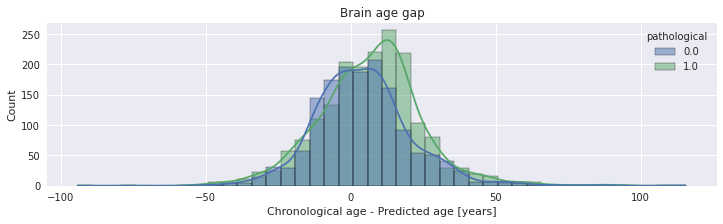

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.histplot(data=all_preds_df, x='gap', hue='pathological', kde=True, ax=ax, binwidth=5)
ax.set_xlabel('Chronological age - Predicted age [years]')
ax.set_title(f'Brain age gap')
fig.savefig(os.path.join(in_dir, 'plots', 'gap_hist.jpg'), bbox_inches='tight')

In [42]:
avg_all_preds_df['gap'].max() - avg_all_preds_df['gap'].min()

100.0

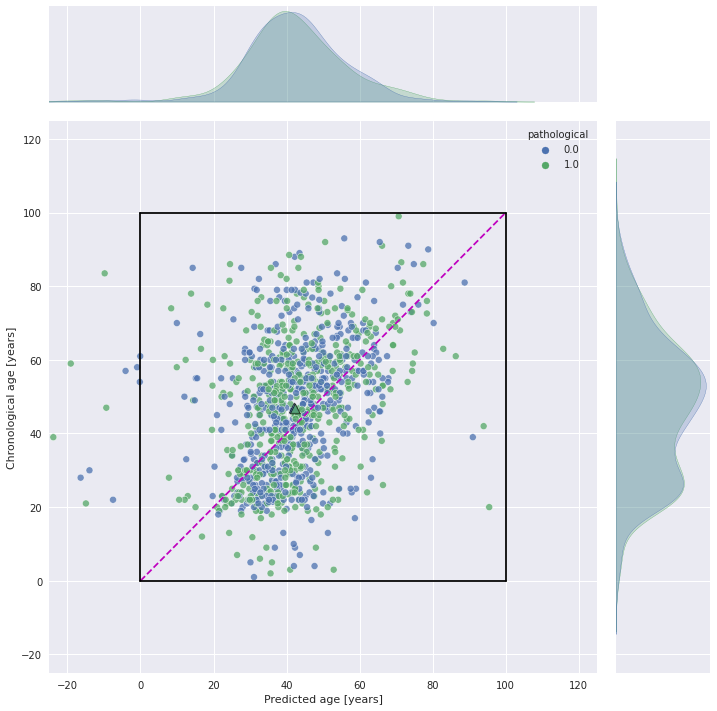

In [43]:
grid = sns.jointplot(data=avg_all_preds_df, x='y_pred', y='y_true',
                     hue='pathological', alpha=.75, height=10,
                     #kind='reg',
                    )
sns.scatterplot(
    data=avg_all_preds_df.groupby('pathological', as_index=False).mean(),  # median looks better
    ax=grid.ax_joint, hue='pathological', x='y_pred', y='y_true', marker='^',
    edgecolor='black', s=100, legend=False, alpha=.75,
)
grid.ax_joint.set_xlim(-25, 125)
grid.ax_joint.set_ylim(-25, 125)
grid.ax_joint.plot([0,100],[0,100], c='m', linestyle='--')
grid.ax_joint.plot([0, 100], [0, 0], c='k')
grid.ax_joint.plot([0, 0], [0, 100], c='k')
grid.ax_joint.plot([0, 100], [100, 100], c='k')
grid.ax_joint.plot([100, 100], [0, 100], c='k')
grid.ax_joint.set_xlabel('Predicted age [years]')
grid.ax_joint.set_ylabel('Chronological age [years]')
grid.fig.savefig(os.path.join(in_dir, 'plots', 'mean_jointplot.jpg'), bbox_inches='tight')

In [44]:
dates = []
for i, date in df[['year', 'month', 'day']].T.iteritems():
    date = '-'.join([str(int(d)) for d in date])
    dates.append(date)
df['date'] = dates

NameError: name 'df' is not defined

In [45]:
df = df.sort_values(['year', 'month', 'day'])

NameError: name 'df' is not defined

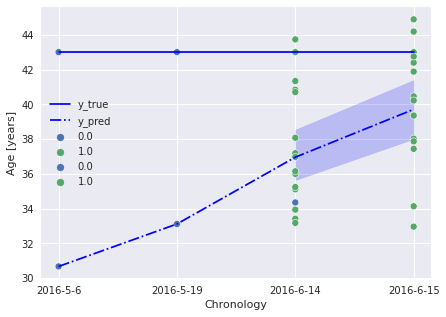

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.lineplot(data=df, y='y_true', x='date',  linestyle='-', ax=ax, label='y_true', color='b')
sns.lineplot(data=df, y='y_pred', x='date', linestyle='-.', ax=ax, label='y_pred', color='b')
sns.scatterplot(data=df, y='y_true', x='date', hue='pathological', ax=ax)
sns.scatterplot(data=df, y='y_pred', x='date', hue='pathological', ax=ax)
ax.legend()
#ax.set_xticks(list(range(len(df))))
#ax.set_xticklabels(dates);
plt.xlabel('Chronology');
ax.set_ylabel('Age [years]');

Text(0.5, 1.0, 'Subject 14951 brain age gap (y_true - y_pred)')

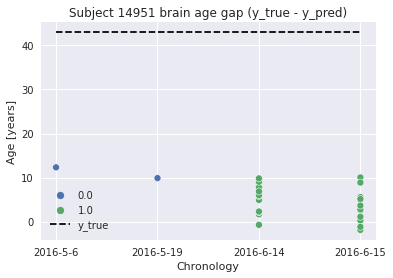

In [21]:
ax = sns.scatterplot(y=df['y_true'] - df['y_pred'], data=df, x='date', hue='pathological')
ax.set_ylabel('Age [years]')
ax.set_xlabel('Chronology')
ax = sns.lineplot(data=df, x='date', y='y_true', color='black', label='y_true', linestyle='--');
ax.set_title(f'Subject {subj} brain age gap (y_true - y_pred)')

In [22]:
df

,y_pred,y_true,pathological,year,month,day,date
0,30.678079,43.0,0.0,2016.0,5.0,6.0,2016-5-6
1,33.118499,43.0,0.0,2016.0,5.0,19.0,2016-5-19
2,34.357824,43.0,0.0,2016.0,6.0,14.0,2016-6-14
3,43.731965,43.0,1.0,2016.0,6.0,14.0,2016-6-14
4,35.099208,43.0,1.0,2016.0,6.0,14.0,2016-6-14
5,41.338068,43.0,1.0,2016.0,6.0,14.0,2016-6-14
6,35.114696,43.0,1.0,2016.0,6.0,14.0,2016-6-14
7,33.419983,43.0,1.0,2016.0,6.0,14.0,2016-6-14
8,38.076003,43.0,1.0,2016.0,6.0,14.0,2016-6-14
9,40.837650,43.0,1.0,2016.0,6.0,14.0,2016-6-14


Text(0, 0.5, 'Count')

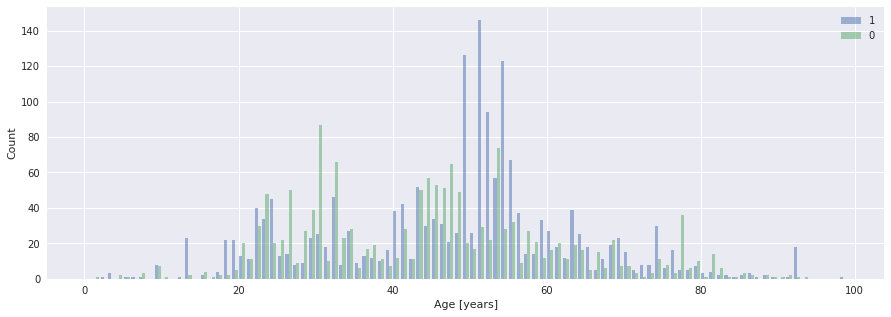

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = ds.description.pathological.unique()
x = [ds.description.age[ds.description.pathological == g] for g in genders]
ax.hist(
    x=x,
    stacked=False,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')

In [35]:
train_description = pd.read_csv(os.path.join(in_dir, 'train_description.csv'), index_col=0)

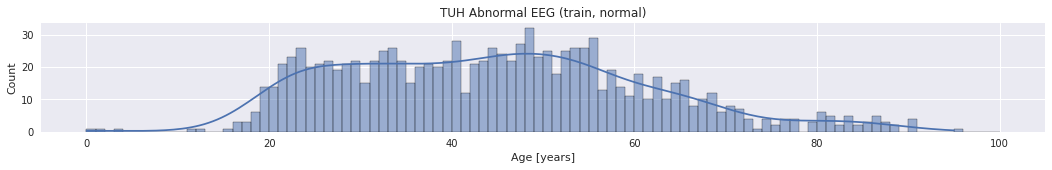

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(train_description, hue_key=None, ax=ax)
ax.set_title('TUH Abnormal EEG (train, normal)')
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
fig.savefig('/home/jovyan/train_hist.jpg', bbox_inches='tight')

In [7]:
with open('/home/jovyan/longitudinal/transition.pkl', 'rb') as f:
    ds = pickle.load(f)

In [15]:
(ds.description['n_samples']/ds.description['sfreq']).min()

120.0